In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, WeightedRandomSampler, BatchSampler
import torch.nn.functional as F
from torchinfo import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import random
import os

In [2]:
# -----------------------
# CONFIG
# -----------------------
pulse_samples = 1000     # n_feat_muon
n_feat_frec = 2500       # n_feat_frec
batch_size = 512
epochs = 120
lr = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
n_classes = 21

# Paths a tus datasets
muon_dataset_path = "muon_dataset_segmented_v3.npz"
simulated_npz_path = "Espectros/spectrum_simulated.npz"
real_npz_path = "Espectros/spectrum_real.npz"

print("Device:", device)



# -----------------------
# CARGA DE DATASET DE MUONES
# -----------------------
data = np.load(muon_dataset_path)
X_muones = data['X']        # shape (num_pulsos, pulse_samples)
y_muones = data['y']        # shape (num_pulsos,)

# -----------------------
# Normalizar pulsos de muones al mismo rango
# -----------------------
# Tomar el máximo global de todos los pulsos
max_global = X_muones.max()

# Escalar todos los pulsos para que el pulso con mayor valor llegue a 1
X_muones = X_muones / (max_global + 1e-8)  # evitar división por cero

# Convertir a tensores PyTorch
X_muones = torch.tensor(X_muones, dtype=torch.float32).unsqueeze(1)  # (N,1,pulse_samples)
y_muones = torch.tensor(y_muones, dtype=torch.long).squeeze()         # (N,)

print(f"Señales de muones: {X_muones.shape}, targets: {y_muones.shape}")





# -----------------------
# CARGA DE ESPECTROS
# -----------------------
def load_npz(path):
    data = np.load(path)
    freq = data['freq']
    att = data['attenuation_db']
    return torch.tensor(freq, dtype=torch.float32), torch.tensor(att, dtype=torch.float32)

sim_freq, H_sim = load_npz(simulated_npz_path)
real_freq, H_real = load_npz(real_npz_path)

# -----------------------
# Normalizar espectros simulados H_sim de 0 a 1
# -----------------------
H_sim_min = H_sim.min()
H_sim_max = H_sim.max()
H_sim_norm = (H_sim - H_sim_min) / (H_sim_max - H_sim_min + 1e-8)  # evitar división por cero

# Repetir para cada ejemplo
H_sim_batch = H_sim_norm.repeat(X_muones.shape[0], 1)  # (N, n_feat_frec)

Device: cuda
Señales de muones: torch.Size([10000, 1, 1000]), targets: torch.Size([10000])


In [3]:
# -----------------------
# DEFINICIÓN DE LA RED
# -----------------------
class TwoBranchNet(nn.Module):
    def __init__(self, n_feat_muon=1000, n_feat_frec=2500, n_classes=21):
        super(TwoBranchNet, self).__init__()
        
        # --- Rama CNN Muones ---
        self.cnn_branch = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=15, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),         
            nn.MaxPool1d(2),
            

            nn.Conv1d(128, 256, kernel_size=5, padding='same'),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Flatten()
        )
        
        # Rama 2: Respuesta en frecuencia simulada (MLP)
        self.mlp_branch = nn.Sequential(
            nn.Linear(n_feat_frec, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1)
        )

        # --- Cabezal de fusión ---
        self.head = nn.Sequential(
            nn.Linear(256*250 + 32, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )
        
    def forward(self, x_muon, x_freq):
        v1 = self.cnn_branch(x_muon)
        v1 = v1.view(v1.size(0), -1)
        v2 = self.mlp_branch(x_freq)
        merged = torch.cat([v1, v2], dim=1)
        out = self.head(merged)
        return out

# -----------------------
# Inicializar modelo
# -----------------------
model = TwoBranchNet(n_feat_muon=pulse_samples, n_feat_frec=n_feat_frec, n_classes=n_classes).to(device)
summary(model, input_size=[(1,1,1000), (1,2500)])

Layer (type:depth-idx)                   Output Shape              Param #
TwoBranchNet                             [1, 21]                   --
├─Sequential: 1-1                        [1, 64000]                --
│    └─Conv1d: 2-1                       [1, 64, 1000]             1,024
│    └─BatchNorm1d: 2-2                  [1, 64, 1000]             128
│    └─LeakyReLU: 2-3                    [1, 64, 1000]             --
│    └─MaxPool1d: 2-4                    [1, 64, 500]              --
│    └─Conv1d: 2-5                       [1, 128, 500]             57,472
│    └─BatchNorm1d: 2-6                  [1, 128, 500]             256
│    └─LeakyReLU: 2-7                    [1, 128, 500]             --
│    └─MaxPool1d: 2-8                    [1, 128, 250]             --
│    └─Conv1d: 2-9                       [1, 256, 250]             164,096
│    └─BatchNorm1d: 2-10                 [1, 256, 250]             512
│    └─LeakyReLU: 2-11                   [1, 256, 250]             --



Pesos de clase (suavizados) calculados: [1.2330286502838135, 1.476717233657837, 1.1231924295425415, 0.8724812865257263, 0.7001100778579712, 0.5865697860717773, 0.5288711786270142, 0.5271201133728027, 1.0454978942871094, 0.07553429156541824, 0.07553429156541824, 0.07553429156541824, 0.07553429156541824, 0.07553429156541824, 0.07553429156541824, 0.07553429156541824, 0.07553429156541824, 0.07553429156541824, 0.07553429156541824, 0.07553429156541824, 0.07553429156541824]
Distribución de clases:
Clase 0: 21 muestras
Clase 1: 10 muestras
Clase 2: 32 muestras
Clase 3: 81 muestras
Clase 4: 299 muestras
Clase 5: 980 muestras
Clase 6: 2221 muestras
Clase 7: 2312 muestras
Clase 8: 44 muestras
Train size: 6000, Val size: 2000, Test size: 2000

Verificando distribución en 3 batches:
Batch 0: [3, 4, 5, 4, 17, 83, 168, 222, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  Clase 0: 3 muestras
  Clase 1: 4 muestras
  Clase 2: 5 muestras
  Clase 3: 4 muestras
  Clase 4: 17 muestras
  Clase 5: 83 muestras
  Cla

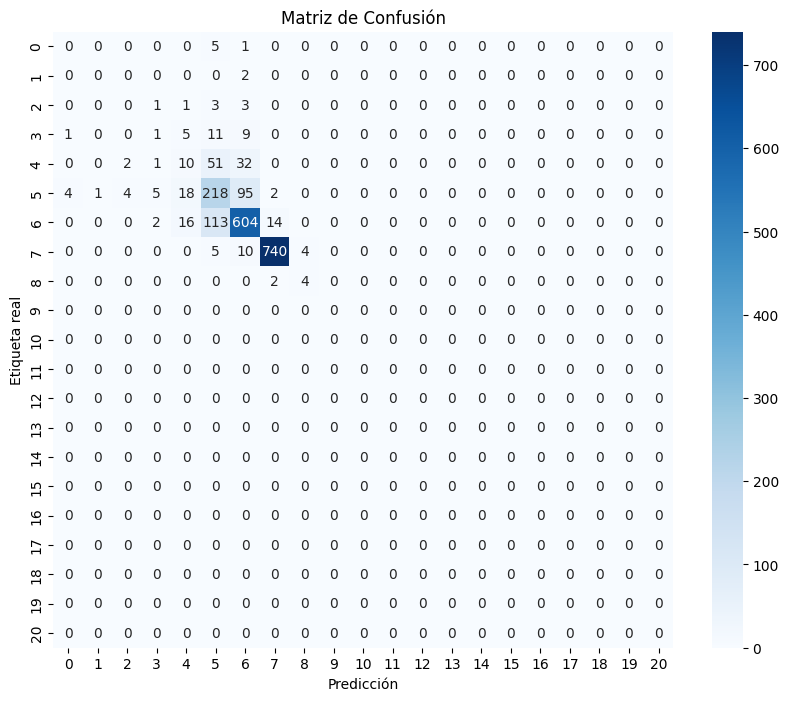


Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         6
           1     0.0000    0.0000    0.0000         2
           2     0.0000    0.0000    0.0000         8
           3     0.1000    0.0370    0.0541        27
           4     0.2000    0.1042    0.1370        96
           5     0.5369    0.6282    0.5790       347
           6     0.7989    0.8064    0.8027       749
           7     0.9763    0.9750    0.9756       759
           8     0.5000    0.6667    0.5714         6

    accuracy                         0.7885      2000
   macro avg     0.3458    0.3575    0.3466      2000
weighted avg     0.7753    0.7885    0.7803      2000



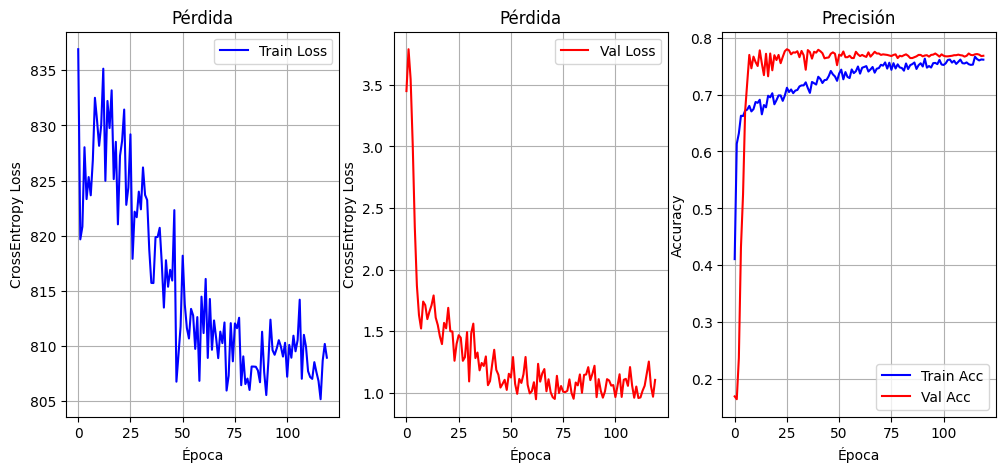


Tiempo de simulacion: 266.1805 segundos


In [4]:
# Iniciar el cronómetro
start_time = time.time()


# Paso 1: Calcular los pesos de clase de forma robusta
# Calcula los pesos sobre el conjunto de datos COMPLETO
y_all_labels = y_muones.cpu().numpy()

# Contar las ocurrencias de cada clase presente
unique_classes, counts = np.unique(y_all_labels, return_counts=True)

# Crear un mapa de conteo para acceso rápido
class_counts = {cls: count for cls, count in zip(unique_classes, counts)}

# Crear el tensor de pesos completo (21 elementos)
class_weights = torch.zeros(n_classes, dtype=torch.float32).to(device)

# Calcular los pesos de clase con una función de suavizado logarítmica
for cls in unique_classes:
    weight = 1.0 / np.log10(1 + class_counts[cls])
    class_weights[cls] = weight

# Asignar un peso mínimo a las clases que tienen peso cero
min_weight = 0.04 # Puedes ajustar este valor
for i in range(n_classes):
    if class_weights[i] == 0:
        class_weights[i] = min_weight

# Normalizar los pesos para que sumen el número de clases
class_weights = class_weights / class_weights.sum() * len(unique_classes)
# ---------------------------

print("\nPesos de clase (suavizados) calculados:", class_weights.tolist())


# -----------------------
# Datasets y DataLoaders
# -----------------------
seed = torch.Generator().manual_seed(311001)
dataset = TensorDataset(X_muones, H_sim_batch, y_muones)

# Primer split: Train+Val vs Test (80/20)
n_total = len(dataset)
n_trainval = int(0.8 * n_total)
n_test = n_total - n_trainval
trainval_dataset, test_dataset = random_split(dataset, [n_trainval, n_test], generator=seed)

# Segundo split: Train vs Val (70/30 del 80%)
n_train = int(0.75 * n_trainval)
n_val  = n_trainval - n_train
train_dataset, val_dataset = random_split(trainval_dataset, [n_train, n_val], generator=seed)



# -----------------------
# Solución usando BatchSampler
# -----------------------

class MinimumClassBatchSampler:
    def __init__(self, dataset, n_classes, batch_size, min_samples_per_class=2):
        self.dataset = dataset
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.min_samples_per_class = min_samples_per_class
        
        # Extraer targets del dataset
        self.targets = self._extract_targets(dataset)
        
        # Obtener índices por clase
        self.class_indices = [[] for _ in range(n_classes)]
        for idx in range(len(dataset)):
            class_id = self.targets[idx]
            if 0 <= class_id < n_classes:
                self.class_indices[class_id].append(idx)
        
        # Verificar distribución
        print("Distribución de clases:")
        for class_id, indices in enumerate(self.class_indices):
            if indices:
                print(f"Clase {class_id}: {len(indices)} muestras")
    
    def _extract_targets(self, dataset):
        """Extrae los targets del dataset"""
        targets = []
        for i in range(len(dataset)):
            if isinstance(dataset, torch.utils.data.Subset):
                original_idx = dataset.indices[i]
                _, _, target = dataset.dataset[original_idx]
            else:
                _, _, target = dataset[i]
            
            class_id = target.item() if torch.is_tensor(target) else target
            targets.append(class_id)
        return targets
    
    def __iter__(self):
        num_batches = len(self.dataset) // self.batch_size
        
        for _ in range(num_batches):
            batch_indices = []
            
            # Para cada clase que tenga muestras, tomar al menos min_samples_per_class
            for class_id in range(self.n_classes):
                if self.class_indices[class_id]:
                    n_to_take = min(self.min_samples_per_class, len(self.class_indices[class_id]))
                    selected = random.sample(self.class_indices[class_id], n_to_take)
                    batch_indices.extend(selected)
            
            # Si nos pasamos del batch_size, recortar
            if len(batch_indices) > self.batch_size:
                batch_indices = random.sample(batch_indices, self.batch_size)
            # Si nos falta, completar con muestras aleatorias
            elif len(batch_indices) < self.batch_size:
                remaining = self.batch_size - len(batch_indices)
                all_indices = list(range(len(self.dataset)))
                additional = random.sample(all_indices, remaining)
                batch_indices.extend(additional)
            
            yield batch_indices
    
    def __len__(self):
        return len(self.dataset) // self.batch_size

# -----------------------
# Configuración CORREGIDA
# -----------------------

# Crear batch sampler
batch_sampler = MinimumClassBatchSampler(
    train_dataset, 
    n_classes=n_classes, 
    batch_size=batch_size, 
    min_samples_per_class=3
)

# Configurar DataLoader sin sampler, usando batch_sampler en su lugar
train_loader = DataLoader(
    train_dataset, 
    batch_sampler=batch_sampler # Usar batch_sampler en lugar de sampler
)

# Val y Test se mantienen igual
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

# -----------------------
# Función de verificación CORREGIDA
# -----------------------

def check_batch_distribution(loader, n_classes, num_batches=3):
    """Verifica la distribución de clases en los primeros batches"""
    print(f"\nVerificando distribución en {num_batches} batches:")
    
    for batch_idx, (x_muon, x_freq, y) in enumerate(loader):
        if batch_idx >= num_batches:
            break
        
        class_counts = torch.bincount(y, minlength=n_classes)
        print(f"Batch {batch_idx}: {class_counts.tolist()}")
        
        # Verificar clases con muestras
        for class_id, count in enumerate(class_counts):
            if count > 0:
                print(f"  Clase {class_id}: {count} muestras")

# Verificar
check_batch_distribution(train_loader, n_classes, num_batches=3)



# -----------------------
# Inicialización de modelo, optimizer y scheduler
# -----------------------
model = TwoBranchNet(n_feat_muon=pulse_samples, n_feat_frec=n_feat_frec, n_classes=n_classes).to(device)

# Añadir regularización L2 (weight decay) al optimizador
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-7)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)





# -----------------------
# Nueva función de pérdida combinada
# -----------------------
def custom_combined_loss(outputs, targets, class_weights=None, min_fraction=0.01, alpha=0.5, beta=0.5):
    """
    Combina la Entropía Cruzada Ponderada, una penalización por fracción mínima y
    una nueva penalización por la diferencia de órdenes de magnitud en los conteos de clase.
    """
    # 1. Pérdida de Entropía Cruzada Ponderada (Cross-Entropy Loss)
    # Castiga las clasificaciones incorrectas a nivel de muestra individual.
    # El peso de las clases se encarga del desbalance.
    ce_loss = nn.CrossEntropyLoss(weight=class_weights)(outputs, targets)

    # 2. Penalización de Fracción Mínima (Min Fraction Loss)
    # Asegura que haya al menos una fracción mínima de muestras para cada clase.
    # Evita que el modelo ignore por completo las clases raras.
    
    # Obtener el conteo de predicciones para cada clase en el lote
    preds = outputs.argmax(dim=1)
    pred_counts = torch.bincount(preds, minlength=outputs.size(1))
    
    # Calcular la fracción de predicciones para cada clase
    n_total = len(targets)
    pred_fractions = pred_counts.float() / n_total
    
    # Calcular la pérdida solo para las clases que están por debajo del umbral mínimo
    min_fraction_loss = 0
    if min_fraction > 0:
      min_fraction_loss = F.relu(min_fraction - pred_fractions).sum()
    
    # 3. Pérdida de Coincidencia de Distribución (Distribution Loss)
    # Castiga las diferencias en los órdenes de magnitud de los conteos de clase
    # entre la distribución real y la predicha.
    
    # Obtener los conteos de las clases reales en el lote
    true_counts = torch.bincount(targets, minlength=outputs.size(1))

    # Tomar el logaritmo de los conteos (sumar 1e-8 para evitar log(0))
    log_true_counts = torch.log10(true_counts.float() + 1e-8)
    log_pred_counts = torch.log10(pred_counts.float() + 1e-8)
    
    # Calcular el error absoluto medio en la escala logarítmica
    distribution_loss = torch.abs(log_pred_counts - log_true_counts).mean()
    
    # 4. Combinar las tres pérdidas
    total_loss = ce_loss + alpha * min_fraction_loss + beta * distribution_loss

    return total_loss


# Hiperparámetros de la pérdida combinada
alpha_value = 500  # Ajusta este valor para controlar la penalización
min_fraction_value = 0.1 # Puedes ajustar este valor también

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for x_muon_batch, x_freq_batch, y_batch in train_loader:
        x_muon_batch = x_muon_batch.to(device)
        x_freq_batch = x_freq_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_muon_batch, x_freq_batch)
        
        # Usar la nueva función de pérdida
        loss = custom_combined_loss(
            output, y_batch,
            class_weights=class_weights,
            min_fraction=min_fraction_value,
            alpha=alpha_value
        )
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_muon_batch.size(0)
        preds = output.argmax(dim=1)
        running_corrects += (preds == y_batch).sum().item()

    epoch_loss = running_loss / n_train
    epoch_acc  = running_corrects / n_train
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)


    # ---- Validación ----
    model.eval()
    val_running_loss, val_running_corrects = 0.0, 0
    all_val_preds, all_val_labels = [], [] # Listas para capturar predicciones y etiquetas
    
    with torch.no_grad():
        for x_muon_batch, x_freq_batch, y_batch in val_loader:
            x_muon_batch = x_muon_batch.to(device)
            x_freq_batch = x_freq_batch.to(device)
            y_batch = y_batch.to(device)

            val_output = model(x_muon_batch, x_freq_batch)
            val_loss = custom_combined_loss(
                val_output, y_batch,
                class_weights=class_weights,
                min_fraction=min_fraction_value,
                alpha=0 # No penalizar en validación
            )
            
            val_running_loss += val_loss.item() * x_muon_batch.size(0)
            preds = val_output.argmax(dim=1)
            val_running_corrects += (preds == y_batch).sum().item()

            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(y_batch.cpu().numpy())

    val_epoch_loss = val_running_loss / n_val
    val_epoch_acc = val_running_corrects / n_val
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)

    scheduler.step(val_epoch_acc)
    
    # --- ANÁLISIS DE ORDEN DE MAGNITUD ---
    # 1. Calcular los conteos de etiquetas reales y predichas
    label_counts = torch.bincount(torch.tensor(all_val_labels), minlength=n_classes)
    pred_counts = torch.bincount(torch.tensor(all_val_preds), minlength=n_classes)
    
    # 2. Tomar el logaritmo de los conteos (sumar 1 para evitar log(0))
    # Logaritmo base 10 es intuitivo para órdenes de magnitud
    log_labels = torch.log10(label_counts.float() + 1e-8)
    log_preds = torch.log10(pred_counts.float() + 1e-8)
    
    # 3. Calcular la métrica de diferencia
    # El error absoluto medio (MAE) en escala logarítmica
    log_mae = torch.abs(log_preds - log_labels).mean()
    
    # 4. Imprimir los resultados
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}")
    
    print(f"  > Log MAE (Órdenes de Magnitud): {log_mae:.4f}")

    
    # Opcional: imprimir los conteos para las clases raras para una inspección rápida
    print("  > Conteo para Clases Raras (reales vs. predichos):")

    # Clases individuales
    clases_individuales = [0, 1, 2, 3, 4, 8]
    for cls in clases_individuales:
        if cls < len(label_counts) and cls < len(pred_counts):
            print(f"    - Clase {cls}: {label_counts[cls]} vs {pred_counts[cls]}")
        else:
            print(f"    - Clase {cls}: (no presente) vs (no presente)")

    # Suma de las clases 9-20
    suma_clases_9_20_labels = 0
    suma_clases_9_20_preds = 0

    for cls in range(9, 21):
        if cls < len(label_counts) and cls < len(pred_counts):
            suma_clases_9_20_labels += label_counts[cls]
            suma_clases_9_20_preds += pred_counts[cls]

    print(f"    - Clases 9-20: {suma_clases_9_20_labels} vs {suma_clases_9_20_preds}")



# -----------------------
# Guardar pesos
# -----------------------
os.makedirs("model_weights", exist_ok=True)
torch.save(model.state_dict(), "model_weights/two_branch_net_v5bis_v2.pth")
print("Pesos guardados en 'model_weights/two_branch_net_v5bis_v2.pth'")

# -----------------------
# Evaluación y métricas
# -----------------------
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x_muon_batch, x_freq_batch, y_batch in test_loader:
        x_muon_batch = x_muon_batch.to(device)
        x_freq_batch = x_freq_batch.to(device)
        y_batch = y_batch.to(device)

        output = model(x_muon_batch, x_freq_batch)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds, labels=list(range(n_classes)))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión")
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(all_labels, all_preds, digits=4))

# -----------------------
# Plot de pérdida y accuracy
# -----------------------
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(train_losses, label="Train Loss", color='blue')
plt.xlabel("Época")
plt.ylabel("CrossEntropy Loss")
plt.title("Pérdida")
plt.grid(True)
plt.legend()

plt.subplot(1,3,2)
plt.plot(val_losses, label="Val Loss", color='red')
plt.xlabel("Época")
plt.ylabel("CrossEntropy Loss")
plt.title("Pérdida")
plt.grid(True)
plt.legend()

plt.subplot(1,3,3)
plt.plot(train_accs, label="Train Acc", color='blue')
plt.plot(val_accs, label="Val Acc", color='red')
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Precisión")
plt.grid(True)
plt.legend()
plt.show()

# Tiempo transcurrido hasta este punto
mid_time = time.time()
print(f"\nTiempo de simulacion: {mid_time - start_time:.4f} segundos")

Accuracy en Test: 78.85%


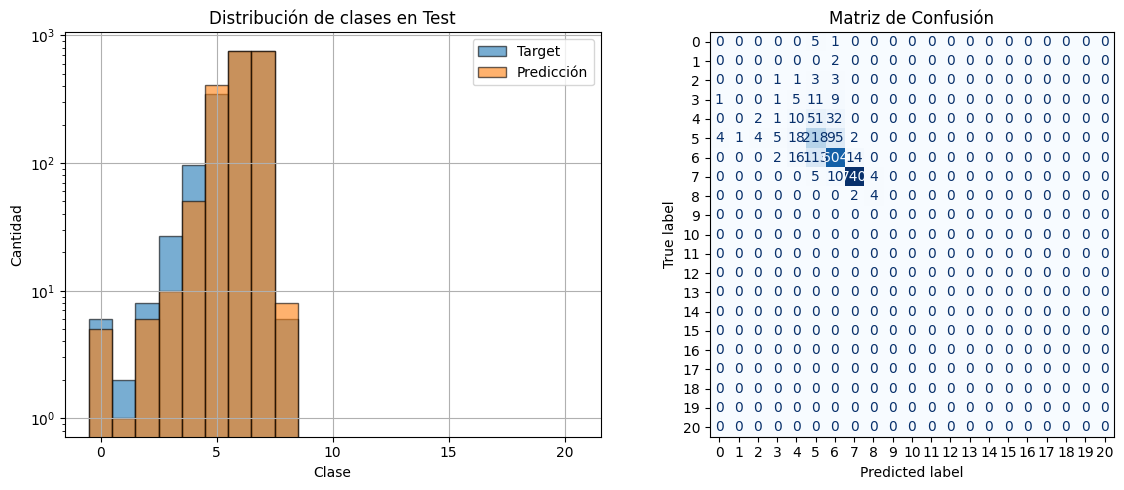

In [5]:
# -----------------------
# Evaluación en Test
# -----------------------
model.eval()
test_preds_all = []
test_targets_all = []

with torch.no_grad():
    for x_muon_batch, x_freq_batch, y_batch in test_loader:
        x_muon_batch = x_muon_batch.to(device)
        x_freq_batch = x_freq_batch.to(device)
        y_batch = y_batch.to(device)

        test_output = model(x_muon_batch, x_freq_batch)
        preds = test_output.argmax(dim=1)   # <- argmax para clases
        test_preds_all.append(preds.cpu())
        test_targets_all.append(y_batch.cpu())

# Concatenar todos los batches
test_preds_all = torch.cat(test_preds_all)
test_targets_all = torch.cat(test_targets_all)

# Accuracy
acc_test = accuracy_score(test_targets_all.numpy(), test_preds_all.numpy())
print(f"Accuracy en Test: {acc_test*100:.2f}%")

# Histograma de clases predichas vs reales
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(test_targets_all.numpy(), bins=np.arange(-0.5, 21.5, 1), alpha=0.6, label="Target", edgecolor='k')
plt.hist(test_preds_all.numpy(), bins=np.arange(-0.5, 21.5, 1), alpha=0.6, label="Predicción", edgecolor='k')
plt.yscale('log')
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.title("Distribución de clases en Test")
plt.legend()
plt.grid(True)

# Matriz de confusión
plt.subplot(1,2,2)
cm = confusion_matrix(test_targets_all.numpy(), test_preds_all.numpy(), labels=np.arange(21))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(21))
disp.plot(ax=plt.gca(), cmap='Blues', colorbar=False)
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()


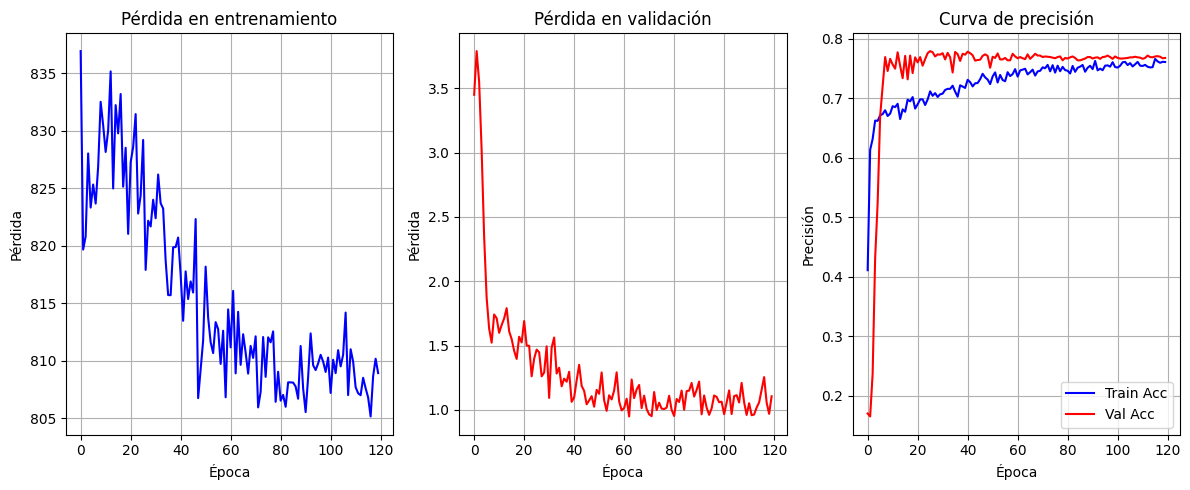

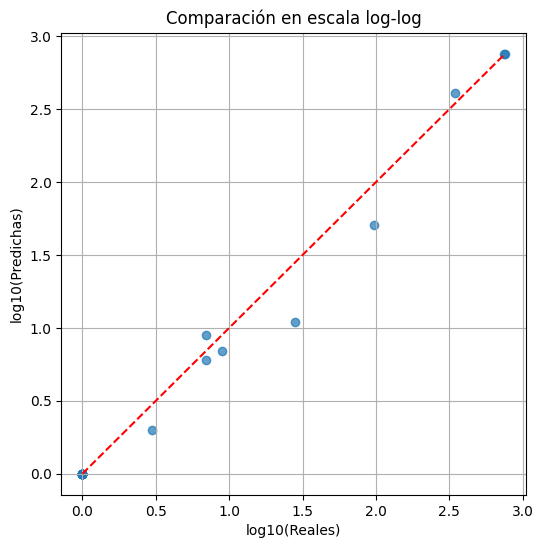

In [9]:
# -----------------------
# 1. Curvas de loss y accuracy
# -----------------------
plt.figure(figsize=(12,5))

# Loss - separado
plt.subplot(1,3,1)
plt.plot(train_losses, label="Train Loss", color='blue')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida en entrenamiento")
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(val_losses, label="Val Loss", color='red')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida en validación")
plt.grid(True)


# Accuracy
plt.subplot(1,3,3)
plt.plot(train_accs, label="Train Acc", color='blue')
plt.plot(val_accs, label="Val Acc", color='red')
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.title("Curva de precisión")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



# -----------------------
# 4. Comparación en escala log-log
# -----------------------
plt.figure(figsize=(6,6))
plt.scatter(np.log10(counts_true + 1), np.log10(counts_pred + 1), alpha=0.7)
max_val = max(np.log10(counts_true.max()+1), np.log10(counts_pred.max()+1))
plt.plot([0, max_val], [0, max_val], 'r--')  # línea y=x
plt.xlabel("log10(Reales)")
plt.ylabel("log10(Predichas)")
plt.title("Comparación en escala log-log")
plt.grid(True)
plt.show()
